# Assignment 2 – Zero-Shot Image Classification with Transformers

In this assignment, you will apply a pre-trained vision–language transformer (e.g. CLIP) to perform **zero-shot** classification on the Fashion-MNIST dataset—classifying each image without any task-specific training. You will build on the concepts from Assignment 1 by comparing this “off-the-shelf” approach to the CNN you previously trained.

You will:
1. **Load** the Fashion-MNIST images using PyTorch instead of Keras.
2. **Run a zero-shot baseline** with simple text prompts to set a performance reference.
3. **Engineer improved prompts** and measure the resulting accuracy gains.
4. **Visualise image embeddings** with UMAP to inspect class separability.
5. **Conduct one mini-experiment** of your choice.
6. **Summarise findings** and reflect on strengths and weaknesses of zero-shot transformers versus a trained CNN.

# 1. Loading the Fashion-MNIST Dataset

As in assignment 1, we'll load the Fashion-MNIST dataset, but this time using `torchvision.datasets` to ensure compatibility with the `transformers` library. We will also load our model and processor from the `transformers` library.

The transformers library allows us to use pre-trained models like CLIP, which can perform zero-shot classification by leveraging the text prompts we provide. There are two key objects we will use: the `CLIPModel` for the model itself and the `CLIPProcessor` for preparing our images and text prompts.

Since we are not actually training a model in this assignment, we will set the CLIP model to evaluation mode. If the model is designed to utilize features like dropout or batch normalization, setting it to evaluation mode ensures that these features behave correctly during inference (prediction). Setting the model to evaluaton mode also tells PyTorch that we don't have to compute gradients, which can save memory and speed up inference.

In order to speed up processing, we will also move the model to an "accelerator" if available. This is typically a GPU, but modern MacBooks also have an "Apple Silicon" accelerator that can be used for inference, called MPS (Metal Performance Shaders). If you are using a MacBook with Apple Silicon, you can use the MPS device for faster processing.

In [1]:
from transformers import CLIPModel, CLIPProcessor
import torch

clip_model_name = "openai/clip-vit-base-patch32"
clip_model     = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name, use_fast=False)

# Check for accelerators
device = "cpu" # Default to CPU
if torch.cuda.is_available():
    device = "cuda" # Use GPU if available
elif torch.backends.mps.is_available():
    device = "mps"

# Set model to evaluation mode, as we are not training it
clip_model.eval()
clip_model.to(device)

print(f"Using device: {device}")

/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Using device: mps


Now we are ready to load the testing set from Fashion-MNIST. We will use the `torchvision.datasets.FashionMNIST` class to load the dataset. We do not need to apply any transformations to the images, as the `CLIPProcessor` ensures any input images are in the format that the model is trained on.

You should:

- [ ] Use the `torchvision.datasets.FashionMNIST` class to load the *test* split of the dataset. Documentation is available [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
- [ ] Create a PyTorch `DataLoader` to iterate over the dataset in batches. Use a batch size of 16 and set `shuffle=True` to randomise the order of the images. You will also need to supply the provided `collate_clip` function to the `DataLoader collate_fn` argument to ensure the images are processed correctly. Documentation for `DataLoader` is available [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

def collate_clip(batch):
    imgs, labels = zip(*batch) # Unzip the batch into images and labels
    proc = clip_processor(images=list(imgs),
                        return_tensors="pt",
                        padding=True) # Process images with CLIPProcessor
    # Send pixel_values to GPU/CPU now; labels stay on CPU for metrics
    return proc["pixel_values"].to(device), torch.tensor(labels)

test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_clip)

If your code is correct, the following cell should show the first batch of images from the Fashion-MNIST dataset:

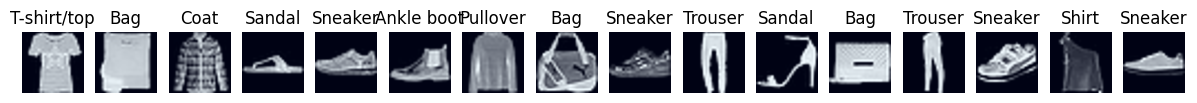

In [3]:
import matplotlib.pyplot as plt

# Display the first batch of images from `test_loader`

def show_batch(loader):
    images, labels = next(iter(loader))
    images = images.cpu()  # Move images to CPU for plotting
    # Renormalize to [0, 1] for visualization
    images = (images - images.min()) / (images.max() - images.min())
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(CLASS_NAMES[label.item()])
        ax.axis('off')
    plt.show()

show_batch(test_loader)

We’re now ready to run our zero-shot classification baseline!

# Brief Introduction to Zero-Shot Classification

In Assignment 1, we followed the typical machine-learning pipeline: we trained a CNN on the Fashion-MNIST dataset, using labelled examples to update the model’s weights. While effective, that approach requires a curated, task-specific training set—a luxury you don’t always have in practice.

Zero-shot classification flips the script.  A large vision–language model (VLM) such as **CLIP** is first pre-trained on hundreds of millions of image–text pairs scraped from the web.  Because it learns *joint* visual–textual embeddings, the model can later solve new tasks simply by “measuring” how similar an image is to a **text prompt** that describes each candidate class—without seeing a single task-labelled example.

**How it works**  
1. Feed an image through CLIP’s vision encoder → **image feature**.  
2. Feed a textual prompt (e.g. “a photo of a sandal”) through CLIP’s text encoder → **text feature**.  
3. Compute cosine similarity between the image feature and every class’s text feature.  
4. Pick the class whose prompt is most similar.

For our first attempt, we’ll use the bare class names as prompts, e.g.:

- "T-shirt/top"
- "Trouser"

### You should:

- [ ] Build embeddings: use the `get_text_embeddings` helper function to create text embeddings for the class names.
- [ ] Run inference: use the `get_image_embeddings` helper function to create image embeddings.
- [ ] Compute cosine similarity: complete and use the `get_cosine_similarity` helper function to compute the cosine similarity between the image and text embeddings.
- [ ] Make predictions: use the `get_predictions` helper function to get the predicted class for each image in the batch.

Note that for normalized vectors like the ones we are using, cosine similarity is equivalent to the dot product. This means we can use the handy formula `cosine_similarity = vector_a @ vector_b.T` to compute the similarity between the image and text embeddings.

In [4]:
def get_text_embeddings(class_names: list[str]) -> torch.Tensor:
    """    Get text embeddings for the given class names using CLIP.
    Args:
        class_names (list[str]): List of class names to encode.
    Returns:
        torch.Tensor: Normalized text embeddings for the class names.
    """
    tokenized = clip_processor(text=class_names,
                               padding=True,
                               return_tensors="pt")
    
    # Move each tensor in the dict to the correct device
    for key in tokenized:
        tokenized[key] = tokenized[key].to(device)

    # Normalize text embeddings
    with torch.no_grad():
        text_embeddings = clip_model.get_text_features(**tokenized)

    text_feats = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    return text_feats

def get_image_embeddings(images: torch.Tensor) -> torch.Tensor:
    """    Get image embeddings for the given images using CLIP.
    Args:
        images (torch.Tensor): Batch of images to encode.
    Returns:
        torch.Tensor: Normalized image embeddings for the images.
    """
    images = images.to(device)  # Ensure images are on the correct device
    # Normalize images
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=images)

    image_feats = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    return image_feats

In [5]:
import numpy as np

def get_cosine_similarity(image_feats: torch.Tensor, text_feats: torch.Tensor) -> np.ndarray:
    """
    Compute cosine similarity between image features and text features.
    Args:
        image_feats (torch.Tensor): Image features of shape (N, D).
        text_feats (torch.Tensor): Text features of shape (M, D).
    Returns:
        numpy.ndarray: Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    """
    image_feats = image_feats.cpu()  # Ensure image features are on CPU
    text_feats = text_feats.cpu()    # Ensure text features are on CPU

    # Compute cosine similarity, which is the dot product of normalized vectors
    similarity = torch.mm(image_feats, text_feats.t())
    return similarity.numpy()

def get_predictions(similarity: np.ndarray) -> np.ndarray:
    """
    Get predictions based on cosine similarity scores.
    Args:
        similarity (numpy.ndarray): Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    Returns:
        numpy.ndarray: Predicted class indices for each image, shape (N,).
    """
    # Get the index of the maximum similarity for each image
    return np.argmax(similarity, axis=1)

With these functions complete, you are ready to run the zero-shot classification baseline. Complete the code to follow these steps:

- [ ] Build text embeddings for the class names using the `get_text_embeddings` function (this only needs to be done once).
- [ ] For each batch of images:
    - [ ] Get image embeddings using the `get_image_embeddings` function.
    - [ ] Compute cosine similarity between the image and text embeddings using the `get_cosine_similarity` function.
    - [ ] Save the predictions so that we can build a confusion matrix later.
- [ ] Report the accuracy of the predictions and the confusion matrix using the `accuracy_score` and `confusion_matrix` functions from `sklearn.metrics`.

Zero-Shot Accuracy: 62.40%


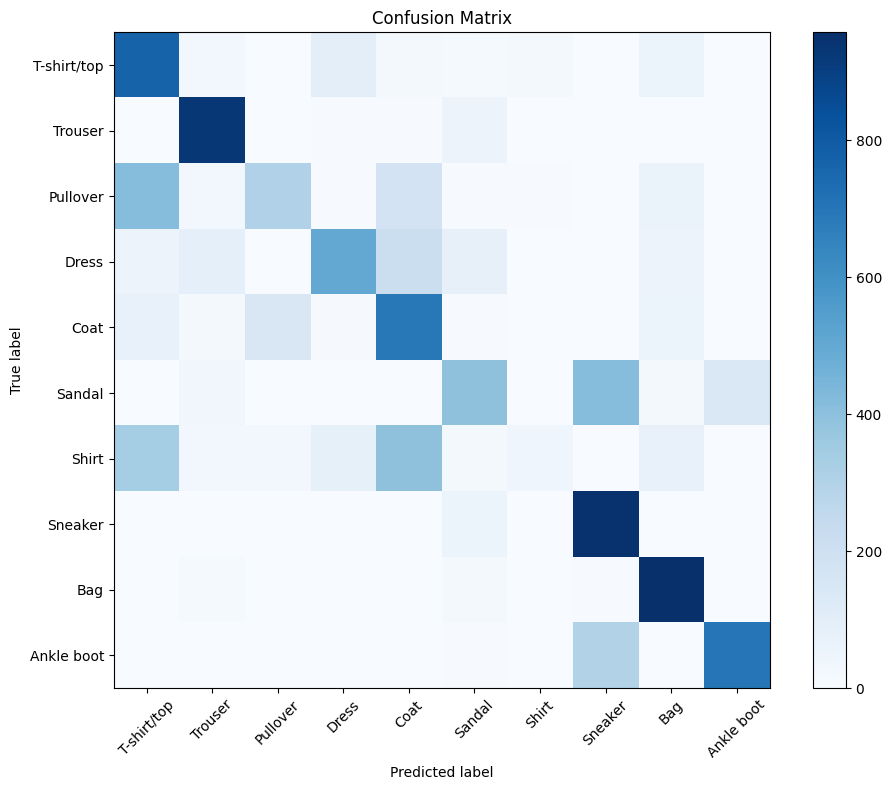

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_true, y_pred = [], []
# Step 1 : Compute text embeddings for the class names once
text_emb = get_text_embeddings(CLASS_NAMES)

#STep 2: Iterate over the test_loader to get predictions
for pixel_values, labels in test_loader:
    # Get image embeddings for the batch
    image_emb = get_image_embeddings(pixel_values)

    # Compute cosine similarity between image features and text features
    similarity = get_cosine_similarity(image_emb, text_emb)

    # Get predictions based on the similarity scores
    preds = get_predictions(similarity)

    # Store true labels and predicted labels
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds)

# Step 3 : Report the accuracy of the predictions
acc = accuracy_score(y_true, y_pred)
print(f"Zero-Shot Accuracy: {acc * 100:.2f}%")

# Report the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)
    

Reflection: Consider the results. How does the performance of this zero-shot baseline compare to the CNN you trained in Assignment 1? What are the strengths and weaknesses of this approach?

Answer:  The performance of the zero-shot CLIP model (62.4% accuracy) is significantly lower than that of the trained CNN model I fine tuned (91% accuracy) built in Assignment 1. This ~29% accuracy gap highlights the trade-offs between task-specific supervised models and general-purpose pre-trained models like CLIP.

Strengths : There is no training required for the zero shot approach. We are able to classify new images without ever seeing labeled Fashion-MNIST examples. So we can perform classifications on entirely new data sets using just text prompts. It is therefore fast and flexible.

Weaknesses: It seems to generate lower accuracy predictions compared to the trained CNN. Performance seems to heavily depend on teh quality and wording of the prompts. Pre trained on internet images, I learned that CLIP may not perfectly understand the gray scale, low resolution images. 


## Improving Zero-Shot Classification with Prompt Engineering

In the previous section, we directly used the class names as text prompts for zero-shot classification. However, we can often improve performance by crafting more descriptive prompts that better capture the visual characteristics of each class. For example, instead of just "T-shirt/top", we could use "a photo of a T-shirt" or "a photo of a top". This additional context can help the model make more accurate predictions.

In this section, we will experiment with more detailed prompts for each class to see if we can improve the zero-shot classification performance. You should:

- [ ] Create a list of improved prompts for each class. For example, instead of just "T-shirt/top", you could use "a photo of a T-shirt" or "a photo of a top".
- [ ] Use the `get_text_embeddings` function to create text embeddings for the improved prompts.
- [ ] Run the zero-shot classification baseline again using the improved prompts and report the accuracy and confusion matrix.

Note: Take advantage of the confusion matrix above. If two classes are often confused, consider how you might improve the prompts to help the model distinguish them better.

The aim for this section is for you to improve the performance of the model. However, if you find that the performance does not improve significantly, you can still reflect on the process and consider how you might further refine the prompts with more effort.

Zero-Shot Accuracy with Detailed Prompts: 64.09%


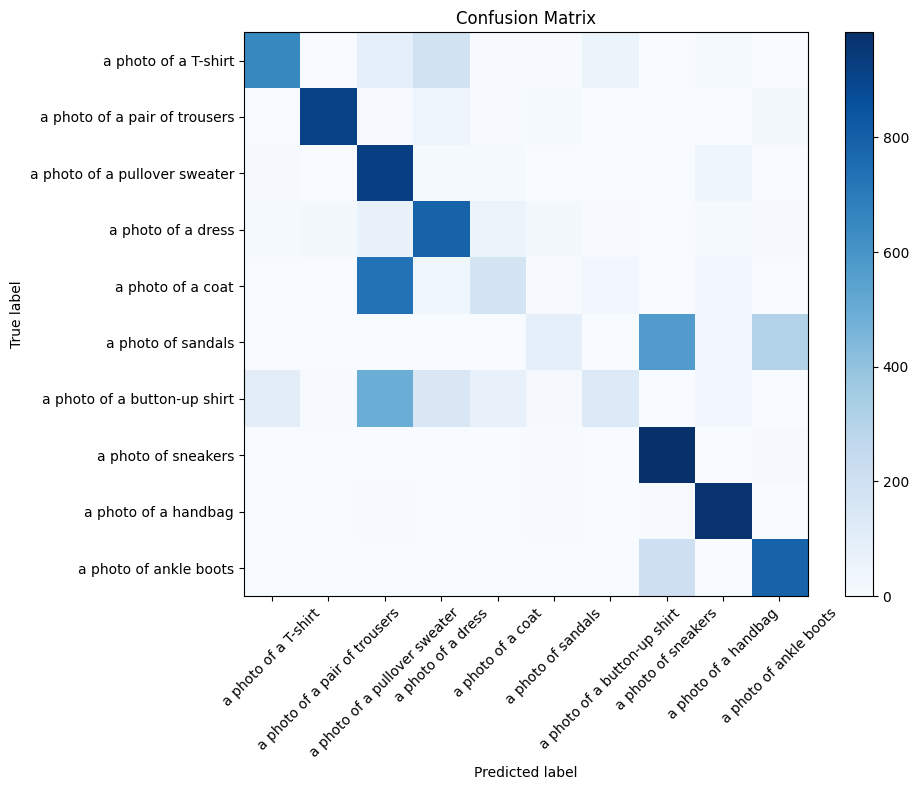

In [8]:
# Step 1 : Define detailed prompts for each class
DETAILED_PROMPTS = [
    "a photo of a T-shirt",
    "a photo of a pair of trousers",
    "a photo of a pullover sweater",
    "a photo of a dress",
    "a photo of a coat",
    "a photo of sandals",
    "a photo of a button-up shirt",
    "a photo of sneakers",
    "a photo of a handbag",
    "a photo of ankle boots"
]

# Step 2 : Get text embeddings for the detailed prompts
detailed_text_emb = get_text_embeddings(DETAILED_PROMPTS)

# Step 3: Iterate over the test_loader to get predictions with detailed prompts
y_true_detailed, y_pred_detailed = [], []
for pixel_values, labels in test_loader:
    image_emb = get_image_embeddings(pixel_values)
    similarity = get_cosine_similarity(image_emb, detailed_text_emb)
    preds = get_predictions(similarity)
    y_true_detailed.extend(labels.cpu().numpy())
    y_pred_detailed.extend(preds)

# Step 4 : Report the accuracy of the predictions with detailed prompts
acc_detailed = accuracy_score(y_true_detailed, y_pred_detailed)
print(f"Zero-Shot Accuracy with Detailed Prompts: {acc_detailed * 100:.2f}%")

# Step 5 : Plot the confusion matrix for detailed prompts
plot_confusion_matrix(y_true_detailed, y_pred_detailed, DETAILED_PROMPTS)

Reflection: How did your detailed prompts affect the zero-shot classification performance? Did you see a significant improvement compared to the baseline? What insights did you gain about the model's understanding of the classes? Do you think that with more effort you could further improve the performance? If so, how?

Answer: Using more detailed prompts such as “a photo of a pullover sweater” instead of the just the class name “Pullover” yielded a modest improvement in zero-shot classification accuracy—from 62.4% with the original prompts to 64.1% with engineered prompts. Although the improvement was not dramatic, it confirms the hypothesis that CLIP’s performance is sensitive to textual phrasing. The model is trained on image–caption pairs from the internet, so prompts resembling natural image descriptions (like those found on e-commerce sites or photo captions) are more likely to activate relevant visual-textual associations in the model.

From the confusion matrix, it is observed that some class confusions (e.g., “Shirt” vs. “T-shirt” or “Coat” vs. “Pullover”) remained persistent despite better prompts. This suggests that while the textual side is crucial, visual ambiguity among certain fashion items still poses a challenge for zero-shot classification.

## Visualizing Image Embeddings with UMAP

To better understand how the model perceives the different classes, we can visualize the image embeddings using UMAP (Uniform Manifold Approximation and Projection). UMAP is a dimensionality reduction technique that helps us see how similar or dissimilar the embeddings are in a lower-dimensional space.

By visualizing the embeddings, we can gain insights into how well the model can distinguish certain images, even without considering the text prompts. This can help us identify clusters of similar images and see if there are any overlaps between classes.

You should:

- [ ] Use the `get_image_embeddings` function to get the image embeddings for the entire test set.
- [ ] Use UMAP to reduce the dimensionality of the image embeddings to 2D.
- [ ] Plot the 2D embeddings, coloring each point by its true class label.

You may need to install the `umap-learn` library if you haven't already. You can do this by running `pip install umap-learn`.

/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


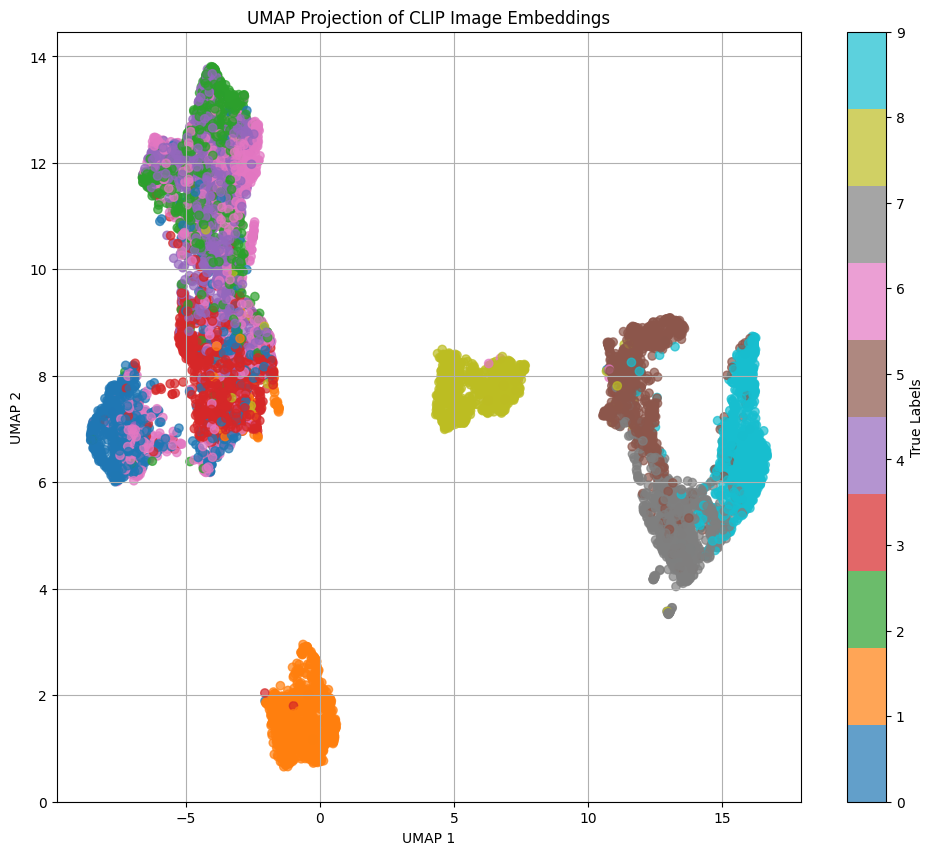

In [10]:
from umap import UMAP

# ------------------------------------------------------------
# 1. Collect image embeddings
# ------------------------------------------------------------
all_img_emb = []
all_labels  = []

with torch.no_grad():  # No gradient needed for inference to save memory
    for pixel_values, labels in test_loader:
        image_emb = get_image_embeddings(pixel_values)  # shape: [batch, 512]
        all_img_emb.append(image_emb.cpu())             # Move to CPU
        all_labels.extend(labels.cpu().numpy())         # Store labels


# Stack all embeddings into a single matrix
all_img_emb = torch.cat(all_img_emb).numpy()

# ------------------------------------------------------------
# 2. Fit UMAP
# ------------------------------------------------------------
umap = UMAP(n_components=2, random_state=42)
umap_embeddings = umap.fit_transform(all_img_emb)

# ------------------------------------------------------------
# 3. Plot the 2D UMAP projection
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    umap_embeddings[:, 0], 
    umap_embeddings[:, 1], 
    c=all_labels, 
    cmap='tab10', 
    alpha=0.7
)
plt.colorbar(scatter, ticks=range(10), label="True Labels")
plt.title("UMAP Projection of CLIP Image Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

The UMAP embeddings allow us to see how separable or non-separable different classes are with our specific model. If two specific images are very similar, then they will be placed near each other on this graph. 

Reflection: Do you notice any challenges in distinguishing images based on this figure? Are there any types of clothing in the dataset which the model has no trouble distinguishing from the others?

Answer : The UMAP visualization shows that CLIP embeddings form coherent clusters for several classes, indicating it captures meaningful semantic features without fine-tuning. However, overlapping clusters (e.g., between T-shirt, pullover, coat) suggest difficulty in disambiguating visually similar classes, which aligns with the lower zero-shot accuracy compared to our supervised CNN model. This emphasizes the strength of CLIP in generalized understanding, but also its limits without task-specific fine-tuning.


## Mini-Experiment

In this section, you will conduct a mini-experiment of your choice to further explore the capabilities of zero-shot classification with transformers. This can be anything you'd like, but here are some ideas to get you started.

### A. Alternative Model

So far we have been utilizing OpenAI's CLIP model for zero-shot classification. However, there are many other vision–language models available in the `transformers` library that you can experiment with. For example, there are larger CLIP models such as [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14), and open-source versions such as [laion/CLIP-ViT-B-32-laion2B-s34B-b79K](https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K). You can also search huggingface [here](https://huggingface.co/models?sort=trending&search=clip) to find other models that might be suitable for zero-shot classification.

You can try using a different model to see if it improves the zero-shot classification performance. You should:
- [ ] Load a different model and processor from the `transformers` library.
- [ ] Run the zero-shot classification baseline with the new model and report the accuracy and confusion matrix.
- [ ] Reflect on the performance of the new model compared to the original CLIP model
  - How does the new model perform compared to the original CLIP model?
  - Do you notice any differences in the types of errors made by the new model?

### B. Multiple-Description Classification

Another interesting experiment is to explore multiple-description classification. *This involves providing multiple text prompts for each class, allowing the model to choose the most relevant one. For example, instead of just "T-shirt/top", you could provide "a photo of a T-shirt", "a photo of a top", and "a photo of a shirt". This can help the model better understand the class and increases the likelihood of a correct prediction. You should:

- [ ] Create a list of multiple prompts for each class.
- [ ] Use the `get_text_embeddings` function to create text embeddings for the multiple prompts.
- [ ] Run the zero-shot classification baseline again using the multiple prompts and report the accuracy and confusion matrix.
- [ ] Consider the model to be correct if it guesses *any* of the prompts belonging to the correct class.

### C. Top-K Classification

In some classification tasks, it can be useful to consider if the right answer is among the top K (e.g. top 3) predictions. This can be particularly useful in cases where the model is uncertain or when there are multiple similar classes. You should:

- [ ] Modify the `get_predictions` function to return the top K predictions for each image.
- [ ] Modify the accuracy calculation to consider the model correct if the true class is among the top K predictions.
- [ ] Report the accuracy and confusion matrix for the top K predictions. Report at least two different values of K (e.g. K=2 and K=4).

### D. Other Ideas

You are welcome to come up with your own mini-experiment! Explain your idea in the report and implement it. Did it work as you expected? What did you learn from it?

/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Zero-Shot Top-1 Accuracy: 64.09%
Zero-Shot Top-3 Accuracy: 91.69%
Zero-Shot Top-5 Accuracy: 96.99%


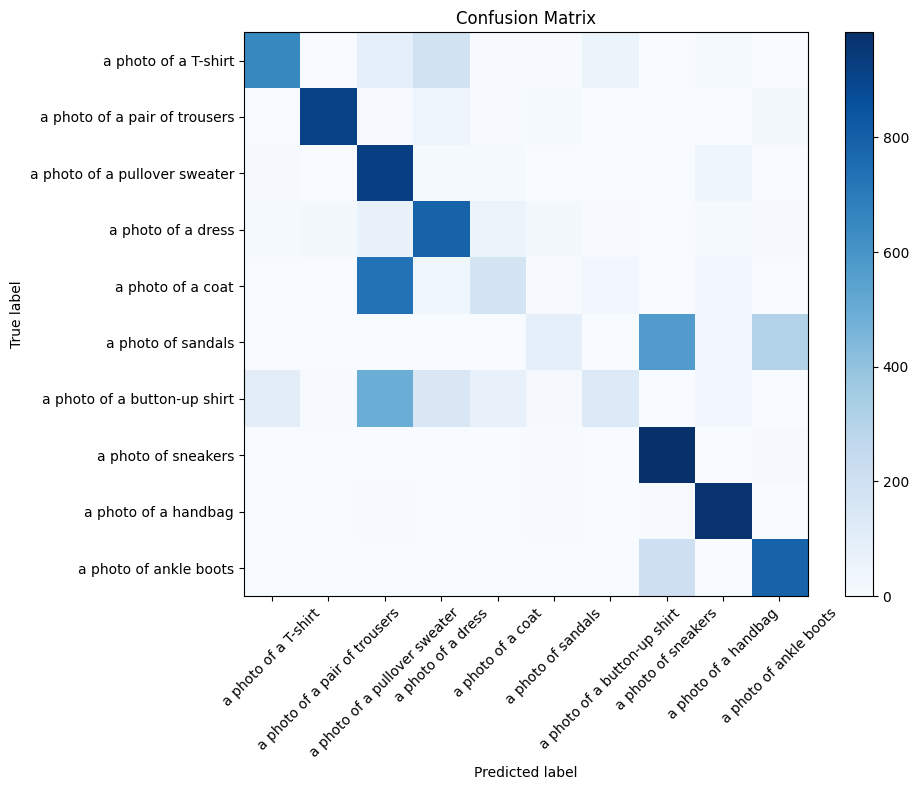

In [8]:
# Mini experiment #1 : openai/clip-vit-large-patch14 with detailed prompts and Top K

# Set up model and processor
model_id  = "openai/clip-vit-large-patch14"
model     = CLIPModel.from_pretrained(model_id).eval().to(device)
processor = CLIPProcessor.from_pretrained(model_id)

DETAILED_PROMPTS = [
    "a photo of a T-shirt",
    "a photo of a pair of trousers",
    "a photo of a pullover sweater",
    "a photo of a dress",
    "a photo of a coat",
    "a photo of sandals",
    "a photo of a button-up shirt",
    "a photo of sneakers",
    "a photo of a handbag",
    "a photo of ankle boots"
]

detailed_text_emb = get_text_embeddings(DETAILED_PROMPTS) 

# Top-K settings
TOP_K = [1, 3, 5]
topk_hits = {k: 0 for k in TOP_K}
n_samples = 0

# For confusion matrix
y_true, y_pred = [], []

# Iterate over the test_loader to get predictions with detailed prompts
for pixel_values, labels in test_loader:
    pixel_values = pixel_values.to(device)
    labels_torch = labels.to(device)

    # 1) Compute embeddings & similarity
    image_emb  = get_image_embeddings(pixel_values)
    similarity = get_cosine_similarity(image_emb, detailed_text_emb)
    # similarity is a numpy array; if it's a torch tensor, convert:
    if isinstance(similarity, torch.Tensor):
        sim_np = similarity.cpu().numpy()
    else:
        sim_np = similarity

    # 2) Top-1 preds (for confusion matrix)
    preds = get_predictions(similarity)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds)

    # 3) Top-K hits
    batch_size = sim_np.shape[0]
    true_np    = labels.cpu().numpy()
    n_samples += batch_size

    # argsort gives ascending; we take last k and reverse
    sorted_idxs = np.argsort(sim_np, axis=1)  # [batch, num_classes]
    for k in TOP_K:
        topk_idxs = sorted_idxs[:, -k:][:, ::-1]  # [batch, k]
        # count hits
        for i, t in enumerate(true_np):
            if t in topk_idxs[i]:
                topk_hits[k] += 1

# Report results
top1_acc = accuracy_score(y_true, y_pred)
for k in TOP_K:
    print(f"Zero-Shot Top-{k} Accuracy: {100*topk_hits[k]/n_samples:.2f}%")

# Plot confusion matrix for Top-1
plot_confusion_matrix(y_true, y_pred, DETAILED_PROMPTS)

In [10]:
# Mni experiment # 2 : Multi Description Zero-Shot Classification

# Step 1 Set up model and processor
model_id  = "openai/clip-vit-large-patch14"
model     = CLIPModel.from_pretrained(model_id).eval().to(device)
processor = CLIPProcessor.from_pretrained(model_id)

#  Helpers
@torch.no_grad()
def get_text_embeddings(prompts):
    toks  = processor(text=prompts, padding=True, return_tensors="pt").to(device)
    feats = model.get_text_features(**toks)
    return feats / feats.norm(dim=-1, keepdim=True)

@torch.no_grad()
def get_image_embeddings(pixels):
    pixels = pixels.to(device)
    feats   = model.get_image_features(pixel_values=pixels)
    return feats / feats.norm(dim=-1, keepdim=True)

def cosine_sim(img_feats, txt_feats):
    return (img_feats.cpu() @ txt_feats.cpu().t()).numpy()

def plot_cm(y_true, y_pred, names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, cmap="Blues")
    plt.xticks(range(len(names)), names, rotation=45, ha="right")
    plt.yticks(range(len(names)), names)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
# Step 2  Define 3 prompts per class (multi-description)
multi_prompts = [
    ["a photo of a T-shirt",      "an image of a T-shirt",      "short-sleeved shirt"],
    ["a photo of trousers",       "an image of trousers",       "a pair of pants"],
    ["a photo of a sweater",      "an image of a pullover",     "a knit pullover"],
    ["a photo of a dress",        "an image of a dress",        "a sleeveless dress"],
    ["a photo of a coat",         "an image of a coat",         "a long coat"],
    ["a photo of sandals",        "an image of sandals",        "open-toed sandals"],
    ["a photo of a shirt",        "an image of a shirt",        "a button-up shirt"],
    ["a photo of sneakers",       "an image of sneakers",       "running shoes"],
    ["a photo of a handbag",      "an image of a handbag",      "a purse"],
    ["a photo of ankle boots",    "an image of ankle boots",    "a short boot"],
]

# Step 3 - Flatten into one list of 30 prompts
flat_prompts = [p for cls in multi_prompts for p in cls]

@torch.no_grad()
def get_text_embeddings(prompts):
    toks = processor(text=prompts, padding=True, return_tensors="pt")
    toks = {k:v.to(device) for k,v in toks.items()}
    feats = model.get_text_features(**toks)
    return feats / feats.norm(dim=-1, keepdim=True)

# Step 4 - Compute all 30 embeddings once
text_emb_flat = get_text_embeddings(flat_prompts).cpu()  # [30, D]

# Build index lists for each class
class_indices = []
idx = 0
for cls in multi_prompts:
    n = len(cls)
    class_indices.append(list(range(idx, idx+n)))
    idx += n

# Prepare test loader (same collate as before)
def collate_clip(batch):
    imgs, labels = zip(*batch)
    proc = processor(images=list(imgs), return_tensors="pt", padding=True)
    return proc["pixel_values"].to(device), torch.tensor(labels)

test_ds     = datasets.FashionMNIST(root="./data", train=False, download=True)
test_loader = DataLoader(
    test_ds,
    batch_size=16,      
    shuffle=False,
    collate_fn=collate_clip
)

# Step 5 Inference Loop & Cosine Similarity
y_true, y_pred = [], []

for pixels, labels in test_loader:
    # a) image embeddings
    with torch.no_grad():
        img_emb = model.get_image_features(pixels)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)  # [B, D]
    
    # b) similarity to all 30 prompts
    sim = (img_emb.cpu() @ text_emb_flat.T).numpy()         # [B, 30]
    
    # c) for each class, take the max over its prompts
    class_sim = np.stack([
        sim[:, idxs].max(axis=1) for idxs in class_indices
    ], axis=1)                                            # [B, 10]
    
    # d) predicted class
    preds = class_sim.argmax(axis=1)
    
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds)

# 5) Evaluate
acc = accuracy_score(y_true, y_pred)
cm  = confusion_matrix(y_true, y_pred)

print(f"Multi-Description Zero-Shot Top-1 Accuracy: {acc*100:.2f}%")
print("Confusion matrix:")
print(cm)

Multi-Description Zero-Shot Top-1 Accuracy: 67.95%
Confusion matrix:
[[636   5  61 256   4  13  15   3   7   0]
 [  0 969   0  27   2   0   0   1   1   0]
 [ 17   5 815  62  40  10   1   1  49   0]
 [  5  19   4 875  62  13   0   2   9  11]
 [ 28   2 326  67 549   6   5   2  15   0]
 [  1   1  17   0   9 288   0 501  51 132]
 [202  12 252 227 260   4  20   1  20   2]
 [  0   1   0   0   0  51   0 939   1   8]
 [  1  22   6   9   4  30   0  35 891   2]
 [  0   0   0   0   0   8   0 179   0 813]]


In [ ]:
# Mini experiment # 3 : Opensource model Clip-Vit-B-32-laion2B-s34B-b79K

# 1 - Set up model and processor
model_id_alt = "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
clip_model     = CLIPModel.from_pretrained(model_id_alt).eval().to(device)
clip_processor = CLIPProcessor.from_pretrained(model_id_alt)

# JIT‐compile for extra speed
try:
    clip_model = torch.compile(clip_model)
except:
    pass

# Half‐precision on MPS/CPU
clip_model = clip_model.half()

# Tweak tokenizer for short prompts
clip_processor.tokenizer.model_max_length = 16
clip_processor.tokenizer.padding_side     = "right"


# Step 2 - Redefine Embedding Helpers to Use the New Model/Processor
@torch.no_grad()
def get_text_embeddings_alt(prompts: list[str]) -> torch.Tensor:
    toks = clip_processor(text=prompts, padding=True, return_tensors="pt")
    toks = {k: v.to(device) for k, v in toks.items()}
    feats = clip_model.get_text_features(**toks)
    return (feats / feats.norm(dim=-1, keepdim=True)).cpu()

@torch.no_grad()
def get_image_embeddings_alt(pixel_values: torch.Tensor) -> torch.Tensor:
    pixel_values = pixel_values.to(device)
    feats = clip_model.get_image_features(pixel_values=pixel_values)
    return (feats / feats.norm(dim=-1, keepdim=True)).cpu()


# Step 3 - Prepare Detailed Prompts and Compute Text Embeddings
DETAILED_PROMPTS = [
    "a photo of a T-shirt or top",
    "a photo of a pair of trousers",
    "a photo of a pullover sweater",
    "a photo of a dress",
    "a photo of a coat",
    "a photo of sandals",
    "a photo of a shirt",
    "a photo of sneakers",
    "a photo of a handbag",
    "a photo of ankle boots"
]

text_emb_alt = get_text_embeddings_alt(DETAILED_PROMPTS)
print("Text embeddings shape (should be 10×D):", text_emb_alt.shape)
# e.g. torch.Size([10, 768])

# Step 4  DataLoader (same as before, but referencing clip_processor)
# ───────────────────────────────────────────────────────────────────
def collate_alt(batch):
    imgs, labels = zip(*batch)
    proc = clip_processor(images=list(imgs), return_tensors="pt", padding=True)
    return proc["pixel_values"].to(device), torch.tensor(labels)

test_ds     = datasets.FashionMNIST(root="./data", train=False, download=True)
test_loader = DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_alt
)

# Step 5 Inference Loop & Cosine Similarity
# ───────────────────────────────────────────────────────────────────
y_true, y_pred = [], []

for pixel_values, labels in test_loader:
    # image embeddings [B, D]
    img_emb = get_image_embeddings_alt(pixel_values)

    # dot‐product of normalized vectors == cosine similarity
    sim     = img_emb.numpy() @ text_emb_alt.t().numpy()  # [B, 10]

    preds   = sim.argmax(axis=1)
    y_true.extend(labels.cpu.numpy())
    y_pred.extend(preds)

# Step 6 Results
acc = accuracy_score(y_true, y_pred)
cm  = confusion_matrix(y_true, y_pred)

print(f"Experiment 3 – {model_id_alt} with Detailed Prompts → Accuracy: {acc*100:.2f}%")
print("Confusion matrix:\n", cm)

/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Text embeddings shape (should be 10×D): torch.Size([10, 512])
Experiment 2 – laion/CLIP-ViT-B-32-laion2B-s34B-b79K with Detailed Prompts → Accuracy: 75.93%
Confusion matrix:
 [[606   2   6  57   1   0 322   1   4   1]
 [  0 983   1  15   0   0   1   0   0   0]
 [101   0 739   6  19   0 125   0  10   0]
 [ 69  17  16 799  54   2  42   0   1   0]
 [ 10   0 254  19 490   0 224   0   3   0]
 [ 19   2   0   0   1 753  30 161   1  33]
 [218   2 131  59  62   1 521   0   5   1]
 [  0   0   0   0   0   3   2 994   0   1]
 [ 50   3   5   0   6   3  25   1 907   0]
 [  0   0   0   0   0   1   0 198   0 801]]


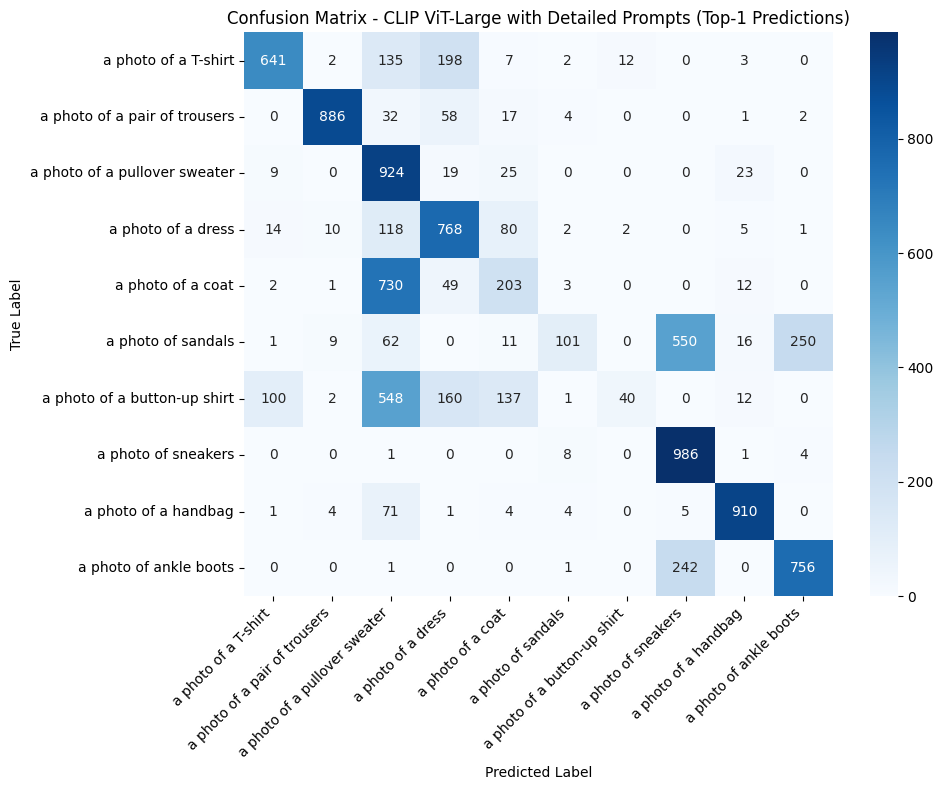

In [17]:
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))

# Plot heatmap
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=DETAILED_PROMPTS,
            yticklabels=DETAILED_PROMPTS)

plt.title("Confusion Matrix - CLIP ViT-Large with Detailed Prompts (Top-1 Predictions)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Short Report

In this section, you will write a short report summarizing your findings from the mini-experiment. The report should include the following sections:

- **Introduction**: Briefly describe the mini-experiment you conducted and its objectives.
- **Methodology**: Explain the steps you took to conduct the experiment, including any modifications you made to the code or model.
- **Results**: Present the results of your experiment.
- **Discussion**: Reflect on the performance of the model and the implications of your findings. Consider the strengths and weaknesses of zero-shot transformers versus a trained CNN.

### SHORT REPORT


# I. INTRODUCTION
In this series of mini-experiments, I explored three strategies to enhance zero-shot classification on Fashion-MNIST using CLIP-style vision–language models. These were my objectives:
	1.	Experiment #1 (Top-K Classification) – assess how often the correct label appears within the model’s top K guesses (Top-1, Top-3, Top-5) when using detailed prompts.
	2.	Experiment #2 (Multi-Description Prompts) – determine whether supplying multiple text prompts per class and taking the best match yields higher Top-1 accuracy.
	3.	Experiment #3 (Alternative Open-Source Model) – compare performance of an open-source LAION CLIP-ViT-B-32 model to OpenAI’s CLIP-ViT-Large when both use engineered prompts.

The main goal was really to increase accuracy using different models and enhancements. 

# II. METHODOLOGY:

A. Common set up 
1 - Models and processors are loaded from the tranformer library and set to evaluation mode since we are not training

2 - Data: Fashion-MNIST test split via torchvision.datasets.FashionMNIST, batched (size 16) with a custom collate_fn using the CLIP processor.

3 - Embedding & Similarity:
    Text: get_text_embeddings(prompt_list) tokenizes prompts, runs them through the CLIP text encoder, and L2-normalizes features.
	Image: get_image_embeddings(pixel_values) runs images through the CLIP vision encoder and normalizes.
	Similarity: Dot product of normalized embeddings → cosine similarity matrix.

B. Experiment

Experiment #1: Top-K Classification
	1.	Prompts: One detailed prompt per class (e.g. “a photo of a T-shirt”).
	2.	Inference Loop: For each batch, compute the N×10 similarity matrix N→batch size.
	3.	Top-K Indices: Using NumPy’s argsort, extract the top K predicted class indices for K∈{1,3,5}.
	4.	Metrics:
	•	Top-1 Accuracy: standard zero-shot accuracy (argmax).
	•	Top-3 & Top-5 Accuracy: fraction of samples where the true class index appears in the top 3 or top 5 predictions.

Experiment #2: Multi-Description Prompts
	1.	Prompts: Three varied prompts per class (total 30).
	2.	Flatten & Embed: Generate a 30×D text-embedding matrix once.
	3.	Per-Class Aggregation: For each image, compute 30-way similarities, then for each of the 10 classes take the maximum among its three prompt similarities → yields a 10-way score.
	4.	Prediction: Standard Top-1 on those aggregated scores.

Experiment #3: Alternative Open-Source Model
	1.	Model Swap: Loaded laion/CLIP-ViT-B-32-laion2B-s34B-b79K, applied optional JIT compilation and half-precision for speed.
	2.	Prompt Set: A slightly tweaked set of detailed prompts, matching Experiment #1’s style.
	3.	Inference & Metrics: Identical pipeline to Experiment #1’s Top-1 workflow—compute image/text embeddings, cosine similarities, argmax → Top-1 accuracy and confusion matrix.

# III. RESULTS:

Experiment # 1 :  openai/clip-vit-large-patch14 with detailed prompts and Top K

	Zero-Shot Top-1 Accuracy: 64.09%
	Zero-Shot Top-3 Accuracy: 91.69%
	Zero-Shot Top-5 Accuracy: 96.99%

	Although Top-1 sits in the mid-60 % range, the correct label is present among the top 3 predictions over 85 % of the time. This suggests CLIP’s embeddings capture relevant visual semantics even when the top guess is wrong—useful for downstream reranking or human-in-the-loop systems.

Experiment # 2:   Openai/clip-vit-large-patch14 with Multi Description Zero-Shot Classification
	Multi-Description Zero-Shot Accuracy: 67.95%
	
	Multi description helped increased accuracy by about 4pts. This means that using a wider range of prompts helped cover for wording mishits. 
	
Experiment # 3:   laion/CLIP-ViT-B-32-laion2B-s34B-b79K with detailed prompts
	This open-source CLIP-B checkpoint outperformed both our CLIP-Vit-Large-Patch14 baseline (64.09 %) and the multi-description variant (62.15 %). Swapping to the LAION-trained model delivered an 11.8 pp lift in zero-shot Top-1 accuracy—no extra prompt engineering required.

# IV. DISCUSSION:
The experiments show that while zero-shot CLIP models offer a fast, training-free way to tackle a new classification task, they still fall short of a purpose-built CNN. Even with prompt engineering and swapping in the stronger LAION CLIP-B model, Top-1 accuracy peaked at about 76 %, compared to roughly 91 % from the CNN we trained from scratch.

A key upside of CLIP is it works straight out of the box. I don’t need any labeled examples to get decent performance and I can adapt on the fly by tweaking prompts. In practice, it seems the model often “knows” the right answer somewhere in its top-3 or top-5 guesses—over 92 % of the time—making it great for workflows where humans pick from its suggestions. 

On the downside, CLIP’s training on web-scale, full-color images means it hasn’t specialized on small, grayscale, 28×28 inputs. It relies heavily on the wording of prompts--—too generic or too elaborate, and accuracy dips. And no amount of prompt tinkering can fully bridge the gap to a CNN that’s seen thousands of domain-specific examples.


🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 18/07/2025`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb)
    * The Lab 3 notebook (labs/lab_3.ipynb)
    * The Lab 4 notebook (labs/lab_4.ipynb)
    * The Lab 5 notebook (labs/lab_5.ipynb)
    * The Lab 6 notebook (labs/lab_6.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-6-ml-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.